In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=50, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel()

In [4]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

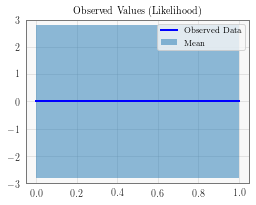

In [5]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [6]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

Iter 1/30 - Loss: 1148.433
Iter 2/30 - Loss: 1121.168
Iter 3/30 - Loss: 1090.604
Iter 4/30 - Loss: 1056.279
Iter 5/30 - Loss: 1029.794
Iter 6/30 - Loss: 994.971
Iter 7/30 - Loss: 969.983
Iter 8/30 - Loss: 945.936
Iter 9/30 - Loss: 917.094
Iter 10/30 - Loss: 884.036
Iter 11/30 - Loss: 843.164
Iter 12/30 - Loss: 786.593
Iter 13/30 - Loss: 708.013
Iter 14/30 - Loss: 613.865
Iter 15/30 - Loss: 522.127
Iter 16/30 - Loss: 430.365
Iter 17/30 - Loss: 348.167
Iter 18/30 - Loss: 275.155
Iter 19/30 - Loss: 217.745
Iter 20/30 - Loss: 172.793
Iter 21/30 - Loss: 121.204
Iter 22/30 - Loss: 81.263
Iter 23/30 - Loss: 43.279
Iter 24/30 - Loss: 5.739
Iter 25/30 - Loss: -23.957
Iter 26/30 - Loss: -37.107
Iter 27/30 - Loss: -75.912
Iter 28/30 - Loss: -92.926
Iter 29/30 - Loss: -115.704
Iter 30/30 - Loss: -126.948


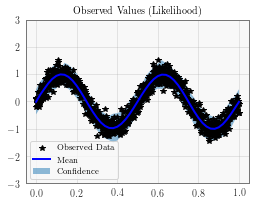

In [7]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model, plot_train_data=True)